In [1]:
from sympy import *
from sympy.physics.mechanics import *
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
#from matplotlib import animation

init_vprinting()

/home/jonat/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [49]:
m1, m2, m3, l1, l2, g, t, u1, u2, lambda1, lambda2 = symbols('m1 m2 m3 l1 l2 g t u1 u2 lambda1 lambda2')
f1x, f1y, f2x, f2y, f3x, f3y = symbols('f1x f1y f2x f2y f3x f3y')
q1x, q1y, q2x, q2y, q3x, q3y = dynamicsymbols('q1x q1y q2x q2y q3x q3y')

M = Matrix([[m1, 0, 0], [0, m2, 0], [0, 0, m3]])
G = Matrix([[0, g], [0, g], [0, g]])
D_of_G = Matrix([[1, 0], [-1, 1], [0, -1]])

r1 = Matrix([[q1x], [q1y]])
r2 = Matrix([[q2x], [q2y]])
r3 = Matrix([[q3x], [q3y]])
Q = Matrix([[r1.T], [r2.T], [r3.T]])

r1e = r1 - r2
r2e = r2 - r3
Qe = Matrix([[r1e.T], [r2e.T]])

q1x_dot = diff(q1x, t)
q1y_dot = diff(q1y, t)
q2x_dot = diff(q2x, t)
q2y_dot = diff(q2y, t)
q3x_dot = diff(q3x, t)
q3y_dot = diff(q3y, t)

r1_dot = Matrix([[q1x_dot], [q1y_dot]])
r2_dot = Matrix([[q2x_dot], [q2y_dot]])
r3_dot = Matrix([[q3x_dot], [q3y_dot]])
r2_ddot = Matrix([[diff(q2x_dot, t)], [diff(q2y_dot, t)]])

r1e_dot = r1_dot - r2_dot
r2e_dot = r2_dot - r3_dot
Qe_dot = Matrix([[r1e_dot.T], [r2e_dot.T]])

f1 = Matrix([[f1x], [f1y]])
f2 = Matrix([[f2x], [f2y]])
f3 = Matrix([[f3x], [f3y]])
F = Matrix([[f1.T], [f2.T], [f3.T]])

R90 = Matrix([[0, -1], [1, 0]])

In [50]:
lambda1 = Matrix([[(1/m1+1/m2)*l1**2, -1/m2*r1e.dot(r2e)], [-1/m2*r1e.dot(r2e), (1/m2+1/m3)*l2**2]]).inv() * Matrix([[r1e.dot(f1/m1-f2/m2)+r1e_dot.dot(r1e_dot)], [r2e.dot(f2/m2-f3/m3)+r2e_dot.dot(r2e_dot)]])
lambda2 = Matrix([[(1/m1+1/m2)*l1**2, -1/m2*r1e.dot(r2e)], [-1/m2*r1e.dot(r2e), (1/m2+1/m3)*l2**2]]).inv() * Matrix([[r1e_dot.dot(r1e_dot)], [r2e_dot.dot(r2e_dot)]])

# lambda1 = matrix_multiply_elementwise(D_of_G.T*M.inv()*D_of_G, Qe*Qe.T).inv() * Matrix([[r1e.dot(f1/m1-f2/m2)+r1e_dot.dot(r1e_dot)], [r2e.dot(f2/m2-f3/m3)+r2e_dot.dot(r2e_dot)]])
# lambda2 = matrix_multiply_elementwise(D_of_G.T*M.inv()*D_of_G, Qe*Qe.T).inv() * Matrix([[r1e_dot.dot(r1e_dot)], [r2e_dot.dot(r2e_dot)]])

# Dynamics
Lambda1 = diag(*lambda1)
Gamma1 = D_of_G*Lambda1*D_of_G.T*Q
Q_ddot = M.inv()*F - G - M.inv()*Gamma1

q1x_ddot_expr = lambdify((q1x, q1y, q2x, q2y, q3x, q3y, q1x_dot, q1y_dot, q2x_dot, q2y_dot, q3x_dot, q3y_dot, f1, f2, f3, m1, m2, m3, l1, l2, g), Q_ddot[0, 0])
q1y_ddot_expr = lambdify((q1x, q1y, q2x, q2y, q3x, q3y, q1x_dot, q1y_dot, q2x_dot, q2y_dot, q3x_dot, q3y_dot, f1, f2, f3, m1, m2, m3, l1, l2, g), Q_ddot[0, 1])
q2x_ddot_expr = lambdify((q1x, q1y, q2x, q2y, q3x, q3y, q1x_dot, q1y_dot, q2x_dot, q2y_dot, q3x_dot, q3y_dot, f1, f2, f3, m1, m2, m3, l1, l2, g), Q_ddot[1, 0])
q2y_ddot_expr = lambdify((q1x, q1y, q2x, q2y, q3x, q3y, q1x_dot, q1y_dot, q2x_dot, q2y_dot, q3x_dot, q3y_dot, f1, f2, f3, m1, m2, m3, l1, l2, g), Q_ddot[1, 1])
q3x_ddot_expr = lambdify((q1x, q1y, q2x, q2y, q3x, q3y, q1x_dot, q1y_dot, q2x_dot, q2y_dot, q3x_dot, q3y_dot, f1, f2, f3, m1, m2, m3, l1, l2, g), Q_ddot[2, 0])
q3y_ddot_expr = lambdify((q1x, q1y, q2x, q2y, q3x, q3y, q1x_dot, q1y_dot, q2x_dot, q2y_dot, q3x_dot, q3y_dot, f1, f2, f3, m1, m2, m3, l1, l2, g), Q_ddot[2, 1])

# Edge Control
k1 = 5
k2 = 5
theta_d = pi/4*cos(pi/4*t)
r1ed = l1*Matrix([[cos(theta_d)], [sin(theta_d)]]) #[0, l1]
r2ed = l2*Matrix([[cos(theta_d)], [-sin(theta_d)]]) #[l2, 0]
r1ed_dot = diff(r1ed, t)
r2ed_dot = diff(r2ed, t)
Qed = Matrix([[r1ed.T], [r2ed.T]])
Qed_dot = diff(Qed, t)
Qed_ddot = diff(Qed_dot, t)

Lambda2 = diag(*lambda2)
Gamma2 = D_of_G*Lambda2*D_of_G.T*Q
Fe = -k1*(Qe-Qed) - k2*(Qe_dot-Qed_dot) + Qed_ddot + D_of_G.T*M.inv()*Gamma2

a1 = R90*r1e/l1
b1 = Fe[0, :].T
u1 = a1.dot(b1) #- g/(r1e[0, 0]/l1)

a2 = -R90*r2e/l2
b2 = Fe[1, :].T
u2 = a2.dot(b2) #- g/(r2e[0, 0]/l2)

f1_control = m1*(u1*R90*r1e/l1) + m1*Matrix([[0], [g]])
f3_control = m3*(u2*R90*r2e/l2) + m3*Matrix([[0], [g]])

# Node Control
k3 = 5
k4 = 5
r2d = Matrix([[0], [0]])
r2d_dot = Matrix([[0], [0]])
r2d_ddot = Matrix([[0], [0]])

x1ed = r1ed[0, 0]
y1ed = r1ed[1, 0]
x2ed = r2ed[0, 0]
y2ed = r2ed[1, 0]
coeff = 1/((1/m1+1/m2)*l1**2*(1/m2+1/m3)*l2**2 - (1/m2*r1ed.dot(r2ed))**2)
a1 = coeff*((1/m2+1/m3)*l2**2*x1ed/-m2 + 1/m2*r1ed.dot(r2ed)*x2ed/m2)
b1 = coeff*((1/m2+1/m3)*l2**2*y1ed/-m2 + 1/m2*r1ed.dot(r2ed)*y2ed/m2)
c1 = coeff*((1/m2+1/m3)*l2**2*r1ed_dot.dot(r1ed_dot) + 1/m2*r1ed.dot(r2ed)*r2ed_dot.dot(r2ed_dot))
a2 = coeff*((1/m1+1/m2)*l1**2*x2ed/m2 + 1/m2*r1ed.dot(r2ed)*x1ed/-m2)
b2 = coeff*((1/m1+1/m2)*l1**2*y2ed/m2 + 1/m2*r1ed.dot(r2ed)*y1ed/-m2)
c2 = coeff*((1/m1+1/m2)*l1**2*r2ed_dot.dot(r2ed_dot) + 1/m2*r1ed.dot(r2ed)*r1ed_dot.dot(r1ed_dot))
A = Matrix([[1+a1*x1ed-a2*x2ed, b1*x1ed-b2*x2ed],
            [a1*y1ed-a2*y2ed, 1+b1*y1ed-b2*y2ed]])
b = m2*(-k3*(r2-r2d) - k4*(r2_dot-r2d_dot) + r2d_ddot) + m2*Matrix([[0], [g]]) - c1*r1ed + c2*r2ed

f2_control = A.adjugate()/(A[0, 0]*A[1, 1]-A[0, 1]*A[1, 0])*b
#f2_control = m2*(-k3*(r2-r2d) - k4*(r2_dot-r2d_dot) + r2d_ddot) + m2*Matrix([[0], [g]])

f1_expr = lambdify((q1x, q1y, q2x, q2y, q3x, q3y, q1x_dot, q1y_dot, q2x_dot, q2y_dot, q3x_dot, q3y_dot, m1, m2, m3, l1, l2, g, t), f1_control)
f2_expr = lambdify((q2x, q2y, q2x_dot, q2y_dot, m1, m2, m3, l1, l2, g, t), f2_control)
f3_expr = lambdify((q1x, q1y, q2x, q2y, q3x, q3y, q1x_dot, q1y_dot, q2x_dot, q2y_dot, q3x_dot, q3y_dot, m1, m2, m3, l1, l2, g, t), f3_control)

#f2_expr(15, -4, 0, 0, 1, 1, 1, 1, 1, 9.81, 0)

In [51]:
m1 = 1
m2 = 10
m3 = 1
l1 = 1
l2 = 1
g = 9.81

dt = 0.01
tf = 15
t = np.arange(0, tf, dt)

q1x_0 = 0
q1y_0 = 0
q2x_0 = l1/sqrt(2)
q2y_0 = -l1/sqrt(2)
q3x_0 = q2x_0
q3y_0 = q2y_0-l2
q1x_dot_0 = 0
q1y_dot_0 = 0
q2x_dot_0 = 0
q2y_dot_0 = 0
q3x_dot_0 = 1
q3y_dot_0 = 0

def ODE(t, y):
    q1x, q1y, q2x, q2y, q3x, q3y, q1x_dot, q1y_dot, q2x_dot, q2y_dot, q3x_dot, q3y_dot = y
    
    f1 = f1_expr(q1x, q1y, q2x, q2y, q3x, q3y, q1x_dot, q1y_dot, q2x_dot, q2y_dot, q3x_dot, q3y_dot, m1, m2, m3, l1, l2, g, t)
    f3 = f3_expr(q1x, q1y, q2x, q2y, q3x, q3y, q1x_dot, q1y_dot, q2x_dot, q2y_dot, q3x_dot, q3y_dot, m1, m2, m3, l1, l2, g, t)
    f2 = f2_expr(q2x, q2y, q2x_dot, q2y_dot, m1, m2, m3, l1, l2, g, t)
    #if t % 0.25 < 0.125:
    # if True:#np.abs((q1x - q2x) - lambdify(('t', 'l1', 'l2'), r1ed[0, 0])(t, l1, l2)) < 0.05:
    #     f2 = f2_expr(q2x, q2y, q2x_dot, q2y_dot, m1, m2, m3, l1, l2, g, t)
    # else:
    #     f2 = np.array([[0], [0]])
    q1x_ddot = q1x_ddot_expr(q1x, q1y, q2x, q2y, q3x, q3y, q1x_dot, q1y_dot, q2x_dot, q2y_dot, q3x_dot, q3y_dot, f1, f2, f3, m1, m2, m3, l1, l2, g)[0]
    q1y_ddot = q1y_ddot_expr(q1x, q1y, q2x, q2y, q3x, q3y, q1x_dot, q1y_dot, q2x_dot, q2y_dot, q3x_dot, q3y_dot, f1, f2, f3, m1, m2, m3, l1, l2, g)[0]
    q2x_ddot = q2x_ddot_expr(q1x, q1y, q2x, q2y, q3x, q3y, q1x_dot, q1y_dot, q2x_dot, q2y_dot, q3x_dot, q3y_dot, f1, f2, f3, m1, m2, m3, l1, l2, g)[0]
    q2y_ddot = q2y_ddot_expr(q1x, q1y, q2x, q2y, q3x, q3y, q1x_dot, q1y_dot, q2x_dot, q2y_dot, q3x_dot, q3y_dot, f1, f2, f3, m1, m2, m3, l1, l2, g)[0]
    q3x_ddot = q3x_ddot_expr(q1x, q1y, q2x, q2y, q3x, q3y, q1x_dot, q1y_dot, q2x_dot, q2y_dot, q3x_dot, q3y_dot, f1, f2, f3, m1, m2, m3, l1, l2, g)[0]
    q3y_ddot = q3y_ddot_expr(q1x, q1y, q2x, q2y, q3x, q3y, q1x_dot, q1y_dot, q2x_dot, q2y_dot, q3x_dot, q3y_dot, f1, f2, f3, m1, m2, m3, l1, l2, g)[0]
    return (q1x_dot, q1y_dot, q2x_dot, q2y_dot, q3x_dot, q3y_dot, q1x_ddot, q1y_ddot, q2x_ddot, q2y_ddot, q3x_ddot, q3y_ddot)

sol = solve_ivp(ODE, (0, tf), (q1x_0, q1y_0, q2x_0, q2y_0, q3x_0, q3y_0, q1x_dot_0, q1y_dot_0, q2x_dot_0, q2y_dot_0, q3x_dot_0, q3y_dot_0), t_eval=t, method="DOP853", rtol=1e-10, atol=1e-10)
q1x, q1y, q2x, q2y, q3x, q3y, q1x_dot, q1y_dot, q2x_dot, q2y_dot, q3x_dot, q3y_dot = sol.y

In [52]:
#bruh = np.vectorize(f1_expr)(q1x, q1y, q2x, q2y, q3x, q3y, q1x_dot, q1y_dot, q2x_dot, q2y_dot, q3x_dot, q3y_dot, m1*np.ones_like(t), m2*np.ones_like(t), m3*np.ones_like(t), l1*np.ones_like(t), l2*np.ones_like(t), g*np.ones_like(t), t)
#f2 = np.vectorize(f2_expr)(q1x, q1y, q2x, q2y, q3x, q3y, q1x_dot, q1y_dot, q2x_dot, q2y_dot, q3x_dot, q3y_dot, m1, m2, m3, l1, l2, g)

f1x = np.zeros_like(t)
f1y = np.zeros_like(t)
f2x = np.zeros_like(t)
f2y = np.zeros_like(t)
f3x = np.zeros_like(t)
f3y = np.zeros_like(t)
for i in range(len(t)):
    f1x[i] = f1_expr(q1x[i], q1y[i], q2x[i], q2y[i], q3x[i], q3y[i], q1x_dot[i], q1y_dot[i], q2x_dot[i], q2y_dot[i], q3x_dot[i], q3y_dot[i], m1, m2, m3, l1, l2, g, t[i])[0, 0]
    f1y[i] = f1_expr(q1x[i], q1y[i], q2x[i], q2y[i], q3x[i], q3y[i], q1x_dot[i], q1y_dot[i], q2x_dot[i], q2y_dot[i], q3x_dot[i], q3y_dot[i], m1, m2, m3, l1, l2, g, t[i])[1, 0]
    f2x[i] = f2_expr(q2x[i], q2y[i], q2x_dot[i], q2y_dot[i], m1, m2, m3, l1, l2, g, t[i])[0, 0]
    f2y[i] = f2_expr(q2x[i], q2y[i], q2x_dot[i], q2y_dot[i], m1, m2, m3, l1, l2, g, t[i])[1, 0]
    f3x[i] = f3_expr(q1x[i], q1y[i], q2x[i], q2y[i], q3x[i], q3y[i], q1x_dot[i], q1y_dot[i], q2x_dot[i], q2y_dot[i], q3x_dot[i], q3y_dot[i], m1, m2, m3, l1, l2, g, t[i])[0, 0]
    f3y[i] = f3_expr(q1x[i], q1y[i], q2x[i], q2y[i], q3x[i], q3y[i], q1x_dot[i], q1y_dot[i], q2x_dot[i], q2y_dot[i], q3x_dot[i], q3y_dot[i], m1, m2, m3, l1, l2, g, t[i])[1, 0]

Text(0.5, 1.0, 'Forces')

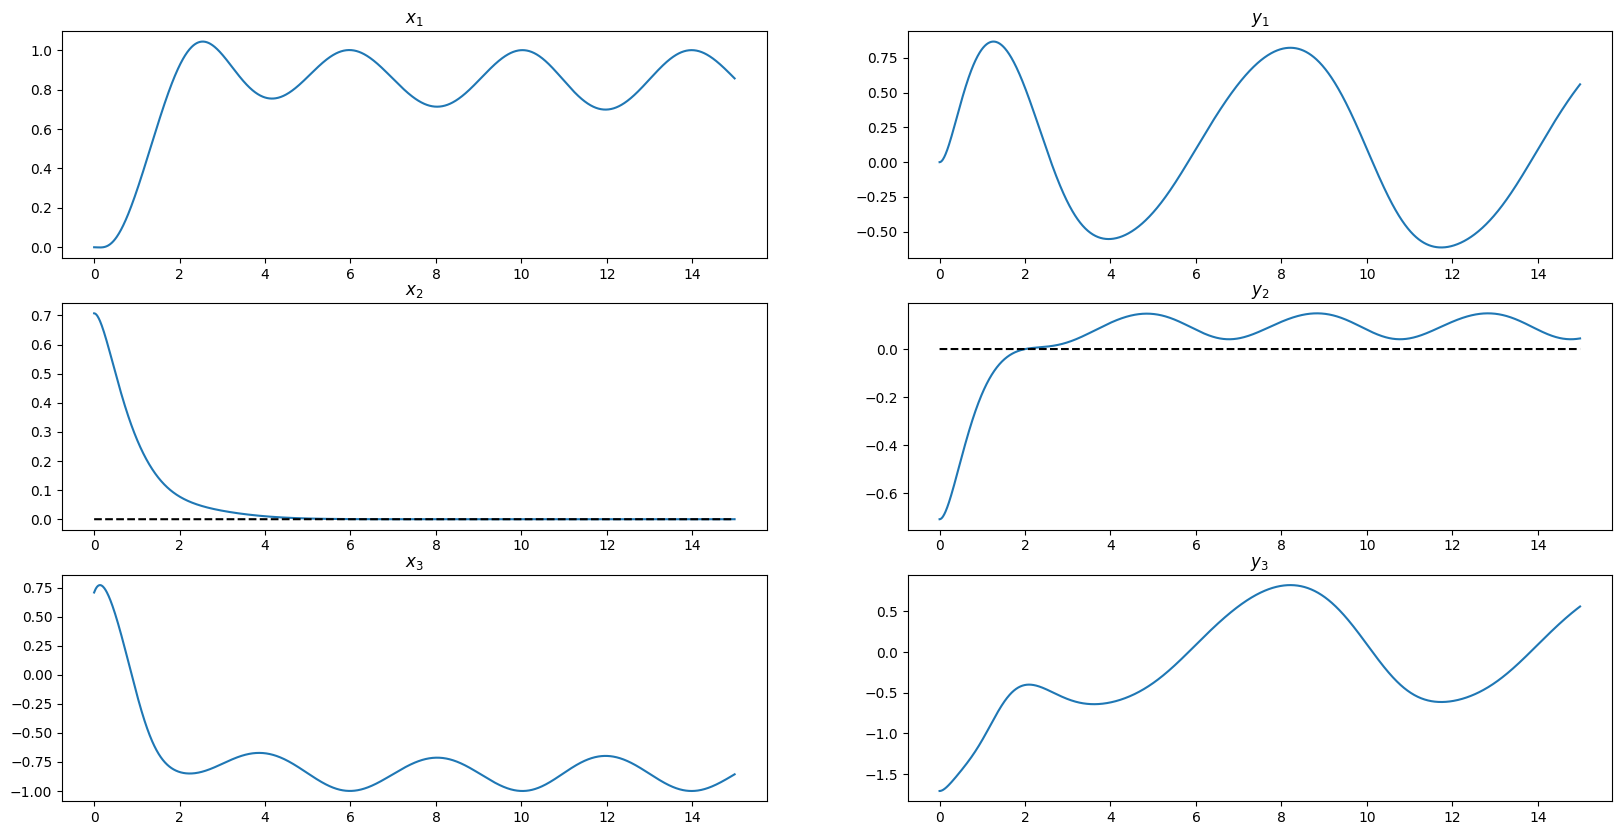

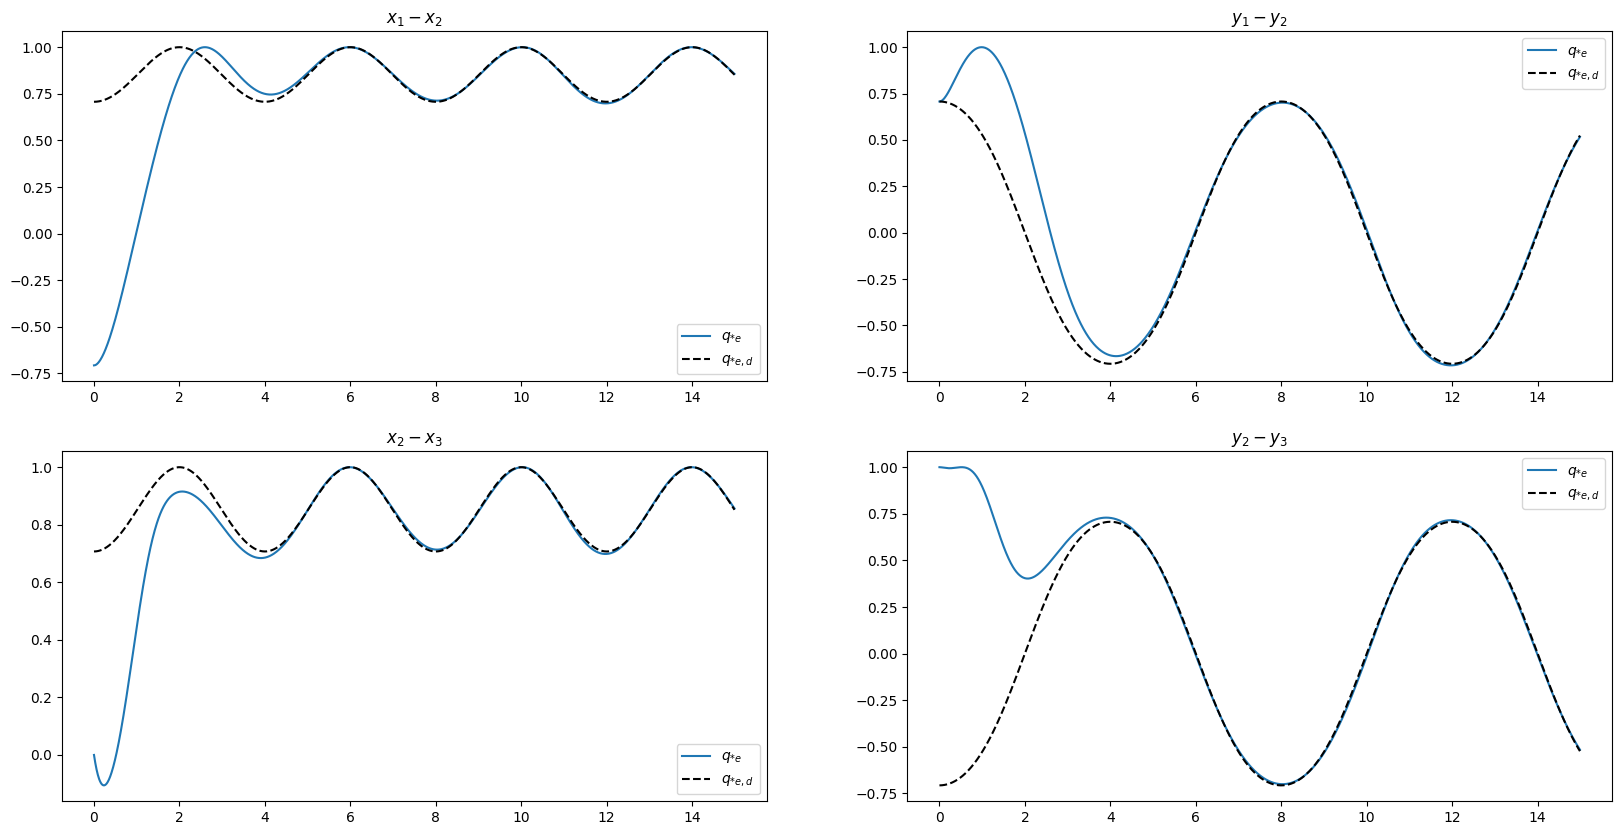

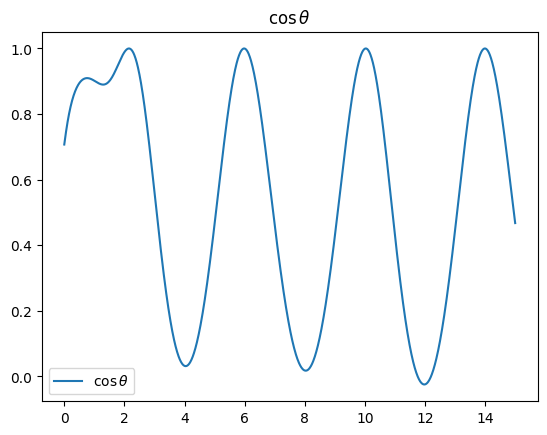

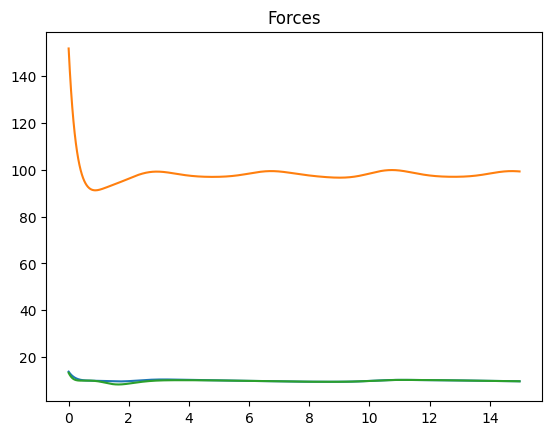

In [53]:
# Nodes
r2d_val = np.array(r2d)

plt.figure(figsize=(20, 10))
plt.subplot(3, 2, 1)
plt.plot(t, q1x, label='q1x')
plt.title('$x_1$')

plt.subplot(3, 2, 2)
plt.plot(t, q1y, label='q1y')
plt.title('$y_1$')

plt.subplot(3, 2, 3)
plt.plot(t, q2x, label='q2x')
plt.plot(t, np.zeros(len(t)), color='black', linestyle='--', label='$r_{2d}$')
plt.title('$x_2$')

plt.subplot(3, 2, 4)
plt.plot(t, q2y, label='q2y')
plt.plot(t, np.zeros(len(t)), color='black', linestyle='--', label='$r_{2d}$')
plt.title('$y_2$')

plt.subplot(3, 2, 5)
plt.plot(t, q3x, label='q3x')
plt.title('$x_3$')

plt.subplot(3, 2, 6)
plt.plot(t, q3y, label='q3y')
plt.title('$y_3$')

# Edges
#Qed_val = Qed.subs({'l1': l1, 'l2': l2})

#r1ed = l1*Matrix([[cos(pi/4*cos(pi/2*t))], [sin(pi/4*cos(pi/2*t))]]) #[0, l1]
#r2ed = l2*Matrix([[-cos(pi/4*cos(pi/2*t))], [sin(pi/4*cos(pi/2*t))]]) #[l2, 0]

plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.plot(t, q1x-q2x, label='$q_{*e}$')
plt.plot(t, l1*np.cos(np.pi/4*np.cos(np.pi/4*t)), color='black', linestyle='--', label='$q_{*e,d}$')
plt.title('$x_1-x_2$')
plt.legend()
#plt.gca().set_ylim(-0.25, 1.25)

plt.subplot(2, 2, 2)
plt.plot(t, q1y-q2y, label='$q_{*e}$')
plt.plot(t, l1*np.sin(np.pi/4*np.cos(np.pi/4*t)), color='black', linestyle='--', label='$q_{*e,d}$')
plt.title('$y_1-y_2$')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(t, q2x-q3x, label='$q_{*e}$')
plt.plot(t, l2*np.cos(np.pi/4*np.cos(np.pi/4*t)), color='black', linestyle='--', label='$q_{*e,d}$')
plt.title('$x_2-x_3$')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(t, q2y-q3y, label='$q_{*e}$')
plt.plot(t, -l2*np.sin(np.pi/4*np.cos(np.pi/4*t)), color='black', linestyle='--', label='$q_{*e,d}$')
plt.title('$y_2-y_3$')
plt.legend()

# Theta
plt.figure()
plt.plot(t, ((q1x-q2x)*(q2x-q3x)+(q1y-q2y)*(q2y-q3y))/(l1*l2), label=r'$\cos\theta$')
#plt.axhline(Qed_val[0, :].dot(Qed_val[1, :])/(l1*l2), color='black', linestyle='--', label=r'$\cos\theta_{d}$')
plt.title(r'$\cos\theta$')
plt.legend()
#plt.gca().set_ylim(-1.01, -0.99)

# Forces
plt.figure()
plt.plot(t, np.linalg.norm(np.array([f1x, f1y]), axis=0))
plt.plot(t, np.linalg.norm(np.array([f2x, f2y]), axis=0))
plt.plot(t, np.linalg.norm(np.array([f3x, f3y]), axis=0))
plt.title('Forces')
#plt.legend()
#plt.gca().set_ylim(-10, 10)